# Read the data

## Regional portraits
https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken.assetdetail.11587760.html  
This is the main data set for the project. It is an official statistic from the Bundesamt für Statistik (BFS) (Federal Statistical Office) of Switzerland. It has data from all 2202 municipalities (as of year 2019) with 31 variables (+10 vote share variables).

### Ingest

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import time

In [2]:
df = pd.read_excel(os.path.join("data", "source", "je-e-21.03.01.xlsx"), header = 5, skipfooter=21)
df.drop(range(0,3), inplace=True) # drop some filler rows between header and data
# use easily readable and consistent column names
new_cols = ['commune_id', 'name', 'residents', 'population_change',
       'population_density', 'foreign_nationals_percent', 'age_0_19',
       'age_20_64', 'age_65_over', 'marriage_rate',
       'divorce_rate', 'birth_rate', 'mortality_rate',
       'households', 'households_size',
       'surface_area', 'settlement_urban_area_percent',
       'settlement_urban_area_change', 'agricultural_area_percent', 'agricultural_area_change',
       'wooded_area_percent', 'unproductive_area_percent', 'employed_total',
       'employed_primary_sector', 'employed_secondary_sector', 'employed_tertiary_sector',
       'workplaces_total', 'workplaces_primary_sector',
       'workplaces_secondary_sector', 'workplaces_tertiary_sector', 'dwelling_vacancy_rate',
       'new_housing_rate', 'social_assistance_rate',
       'vote_share_fdp', 'vote_share_cvp', 'vote_share_sp', 'vote_share_svp', 'vote_share_evp', 'vote_share_glp', 'vote_share_bdp', 'vote_share_pda',
       'vote_share_gps', 'vote_share_rightwing']
df.columns = new_cols
df.set_index("commune_id", inplace=True)

In [3]:
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,vote_share_fdp,vote_share_cvp,vote_share_sp,vote_share_svp,vote_share_evp,vote_share_glp,vote_share_bdp,vote_share_pda,vote_share_gps,vote_share_rightwing
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.66228,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,16.421,2.49797,11.5651,30.381,3.22747,14.3173,1.26372,0.16211,15.0505,3.82065
2.0,Affoltern am Albis,12229.0,10.2606,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,13.3854,4.53534,14.6453,30.3069,6.61856,12.6666,2.00145,0.198718,12.5906,1.55552
3.0,Bonstetten,5548.0,7.54022,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,15.355,3.86796,16.7429,26.1163,4.19402,16.2379,1.28403,0.176013,12.3685,1.38502


In [4]:
df.tail(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,vote_share_fdp,vote_share_cvp,vote_share_sp,vote_share_svp,vote_share_evp,vote_share_glp,vote_share_bdp,vote_share_pda,vote_share_gps,vote_share_rightwing
commune_id,,,,,,,,,,,,,,,,,,,,,
6808.0,Clos du Doubs,1286.0,1.98255,20.825911,8.320373,18.895801,56.143079,24.961120,3.862495,1.544998,...,4.48239,33.2978,21.5582,14.301,10.2455,*,*,*,16.1153,*
6809.0,Haute-Ajoie,1095.0,-5.19481,26.752993,7.671233,18.264840,56.347032,25.388128,3.638017,1.819009,...,8.39002,37.8685,19.3878,18.7075,4.19501,*,*,*,11.4512,*
6810.0,La Baroche,1162.0,-2.27082,37.399421,6.282272,21.514630,54.905336,23.580034,1.710864,1.710864,...,13.7738,27.6596,16.3494,20.2688,9.18253,*,*,*,12.766,*


In [5]:
df.shape

(2202, 42)

### Missing values

In [6]:
# social assistance rate X = keine Angabe aus Datenschutzgründen (weniger als 6 unterstützte Personen)
# action: set to zero
df["social_assistance_rate"].replace(to_replace=["X"], value=0, inplace=True)

In [7]:
# employed/workplaces: X = keine Angabe aus Datenschutzgründen (Source: Beschäftigte in aktiven Unternehmen, 2017, 23811_131.xlsx)
# action: set to zero in *_sector, calculate *_total = sum(*_sectors)
for col in ["employed_primary_sector", "employed_secondary_sector", "employed_tertiary_sector",
           "workplaces_primary_sector", "workplaces_secondary_sector", "workplaces_tertiary_sector"]:
    df[col].replace(to_replace=["X"], value=0, inplace=True)

idx_emp = df["employed_total"] == "X"
df.loc[idx_emp, "employed_total"] = df[idx_emp][["employed_primary_sector", "employed_secondary_sector", "employed_tertiary_sector"]].sum(axis=1)
idx_wpl = df["workplaces_total"] == "X"
df.loc[idx_wpl, "workplaces_total"] = df[idx_wpl][["workplaces_primary_sector", "workplaces_secondary_sector", "workplaces_tertiary_sector"]].sum(axis=1)

In [8]:
# vote shares: * No candidate in this canton or communes
# action: set to zero
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
for col in vote_share_cols:
    df[col].replace(to_replace=["*"], value=0, inplace=True)

# add a column with the total; this is usually not 100%
df["vote_share_total"] = df[vote_share_cols].sum(axis=1)

df = df.apply(pd.to_numeric, errors='ignore')

### Calculate political orientation value

In [9]:
# calculate the po-values
# same order of parties as in vote_share_cols is important
party_lr_dict = {"fdp": 1, "cvp": 0, "sp": -1, "svp": 2, "evp": 0, "glp": 0, "bdp": 1, "pda": -2, "gps": -2, "rightwing": 2 }
party_lr_array = np.array(list(party_lr_dict.values()))
df["po_value"] = np.dot(df[vote_share_cols].values, party_lr_array) / df["vote_share_total"]
# there are six small communes that don't have vote results
# df[df["po_value"].isna()]
df.dropna(subset=["po_value"], inplace=True)

## Languages
https://www.atlas.bfs.admin.ch/maps/13/de/12474_3175_235_227/20584.html  
This contains one variable that contains the language for each commune (2255 communes, 2017).

### Ingest

In [10]:
df_lang = pd.read_excel(os.path.join("data", "source", "20584_131.xlsx"), header=4, skipfooter=11)
new_cols = ['commune_id', 'name', "language" ]
df_lang.columns = new_cols
df_lang.set_index("commune_id", inplace=True)
df_lang.replace({ "Deutsches Sprachgebiet": "de", "Französisches Sprachgebiet": "fr", 
                  "Italienisches Sprachgebiet": "it", "Rätoromanisches Sprachgebiet": "rm"}, inplace=True)

In [11]:
df_lang.head(3)

,name,language
commune_id,,
1,Aeugst am Albis,de
2,Affoltern am Albis,de
3,Bonstetten,de


In [12]:
df_lang.tail(3)

,name,language
commune_id,,
6808,Clos du Doubs,fr
6809,Haute-Ajoie,fr
6810,La Baroche,fr


### Join and fix
There were [commune mergers](#commune-mergers) between 2017 and 2020. Some languages are missing and have to be manually looked up and added.

In [13]:
df = df.join(df_lang, how="left", rsuffix="_")
df.drop(columns="name_", inplace=True)
idx_na = df["language"].isna()
df.loc[idx_na, ["name", "language"]]

,name,language
commune_id,,
292.0,Stammheim,NaN
293.0,Wädenswil,NaN
294.0,Elgg,NaN
295.0,Horgen,NaN
889.0,Thurnen,NaN
2117.0,Villaz,NaN
2237.0,Prez,NaN
3544.0,Bergün Filisur,NaN
3714.0,Rheinwald,NaN


In [14]:
# manual lookup of missing languages (new communes through mergers)
df.loc[[292, 293, 294, 295, 889, 3544, 3714], "language"] = "de"
df.loc[[2117, 2237, 6417], "language"] = "fr"
df.loc[5287, "language"] = "it"

## Health insurance premiums
https://www.bag.admin.ch/bag/en/home/versicherungen/krankenversicherung/krankenversicherung-versicherer-aufsicht/praemienregionen.html  
The reference area are communes, but the premiums are given per cantons, optionally divided into three premium regions. Region 1 is the most expensive and region 3 is the least expensive. This depends on the health costs of the communes. Some cantons don't have regions, they have region 0 in the data.

The variables contain the average health premium cost (over all insurance companies) for the canton/region.

### Ingest

In [15]:
df_health = pd.read_excel(os.path.join("data", "source", "praemienregionen-version-maerz-2020.xlsx"), sheet_name="D_PRIM", header=15)
new_cols = ['commune_id', 'canton', "name", "health_region", "health_premium_child", "health_premium_young",
            "health_premium_adult" ]
df_health.columns = new_cols
df_health.set_index("commune_id", inplace=True)
# besides the premiums, we also keep the canton, it is a useful variable (it is also contained in the commune directory, of course)

In [16]:
df_health.head(3)

,canton,name,health_region,health_premium_child,health_premium_young,health_premium_adult
commune_id,,,,,,
1,ZH,Aeugst am Albis,3,90.31,242.1,335.73
2,ZH,Affoltern am Albis,3,90.31,242.1,335.73
3,ZH,Bonstetten,3,90.31,242.1,335.73


In [17]:
df_health.tail(3)

,canton,name,health_region,health_premium_child,health_premium_young,health_premium_adult
commune_id,,,,,,
6808,JU,Clos du Doubs,0,101.16,267.96,406.54
6809,JU,Haute-Ajoie,0,101.16,267.96,406.54
6810,JU,La Baroche,0,101.16,267.96,406.54


### Join and fix
There were [commune mergers](#commune-mergers) between 2019 and 2020. Some communes are missing and values are taken from one of the pre-merger communes (it doesn't matter which one, they were all in the same region).

In [18]:
df = df.join(df_health, how="left", rsuffix="_")
df.drop(columns="name_", inplace=True)
idx_na = df["health_premium_adult"].isna()
df.loc[idx_na, ["name", "canton", "health_region", "health_premium_child", "health_premium_young", "health_premium_adult"]]

,name,canton,health_region,health_premium_child,health_premium_young,health_premium_adult
commune_id,,,,,,
889.0,Thurnen,NaN,NaN,NaN,NaN,NaN
2117.0,Villaz,NaN,NaN,NaN,NaN,NaN
2237.0,Prez,NaN,NaN,NaN,NaN,NaN


In [19]:
# manual lookup of missing values (new communes through mergers)
# all ex communes have same values
# df_health.loc[[873, 874, 876]]
# df_health.loc[[2111, 2116]]
# df_health.loc[[2185, 2213, 2221]]
cols = ["canton", "health_region", "health_premium_child", "health_premium_young", "health_premium_adult"]
df.loc[889, cols] = df_health.loc[873, cols]
df.loc[2117, cols] = df_health.loc[2111, cols]
df.loc[2237, cols] = df_health.loc[2185, cols]

In [20]:
# health region zero: cantons that have no regions at all
# their premiums are closest to region 2 premiums and we set them as 2
df.groupby(by="health_region").mean()["health_premium_adult"]

health_region
0.0    360.611174
1.0    406.027564
2.0    367.668021
3.0    328.875167
Name: health_premium_adult, dtype: float64

In [21]:
idx_reg0 = (df["health_region"] == 0)
df.loc[idx_reg0, "health_region"] = 2

## Religion
https://www.atlas.bfs.admin.ch/maps/13/de/15297_3522_107_70/24071.html  
The reference area are cantons, not communes. The original variables contain the absolute number of members of religions (or none religion). I calculate the share per resident instead to get a useful number.

### Ingest

In [22]:
df_rel = pd.read_excel(os.path.join("data", "source", "24071_131.xlsx"), header=2, skipfooter=12)
df_rel.drop(index=[0,1,2], inplace=True)

# replace canton name with code
map_canton_code = {
    "Zürich": "ZH",
    "Bern": "BE",
    "Luzern": "LU",
    "Uri": "UR",
    "Schwyz": "SZ",
    "Obwalden": "OW",
    "Nidwalden": "NW",
    "Glarus": "GL",
    "Zug": "ZG",
    "Freiburg": "FR",
    "Solothurn": "SO",
    "Basel-Stadt": "BS",
    "Basel-Landschaft": "BL",
    "Schaffhausen": "SH",
    "Appenzell Ausserrhoden": "AR",
    "Appenzell Innerrhoden": "AI",
    "St. Gallen": "SG",
    "Graubünden": "GR",
    "Aargau": "AG",
    "Thurgau": "TG",
    "Tessin": "TI",
    "Waadt": "VD",
    "Wallis": "VS",
    "Neuenburg": "NE",
    "Genf": "GE",
    "Jura": "JU"
}

df_rel["canton"] = df_rel["Unnamed: 1"].map(map_canton_code)
df_rel.drop(columns=["Unnamed: 0", "Unnamed: 1"], inplace=True)
df_rel.set_index("canton", inplace=True)
df_rel.columns = ["residents_15", "rel_res_rk", "rel_res_ref", "rel_res_other", "rel_res_none"]

### Missing values and fixes

In [23]:
# "-" is missing value
df_rel.replace("–", "0", inplace=True)
df_rel = df_rel.astype({"rel_res_other": "float"}, inplace=True)

In [24]:
# calculate the religion share per residents instead of absolute numbers
for x in ["rk", "ref", "other", "none"]:
    df_rel["rel_share_" + x] = df_rel["rel_res_" + x] / df_rel["residents_15"]
    df_rel.drop(columns=["rel_res_" + x], inplace=True)
df_rel.drop(columns=["residents_15"], inplace=True)
df_rel = df_rel.round(6)

In [25]:
df_rel.head(3)

,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none
canton,,,,
ZH,0.261692,0.282363,0.152199,0.293655
BE,0.154544,0.502517,0.122354,0.208324
LU,0.603496,0.100367,0.105124,0.181195


In [26]:
df_rel.tail(3)

,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none
canton,,,,
NE,0.210764,0.198327,0.109749,0.460555
GE,0.324776,0.089737,0.142110,0.414523
JU,0.669221,0.086567,0.073293,0.155397


### Join

In [27]:
df = df.reset_index().merge(df_rel, how="left", left_on="canton", right_on="canton").set_index('commune_id')

In [28]:
idx_na = df["rel_share_rk"].isna()
df.loc[idx_na, ["name", "rel_share_rk", "rel_share_ref", "rel_share_other", "rel_share_none"]]

,name,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none
commune_id,,,,,


In [29]:
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,language,canton,health_region,health_premium_child,health_premium_young,health_premium_adult,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,de,ZH,3.0,90.31,242.1,335.73,0.261692,0.282363,0.152199,0.293655
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,de,ZH,3.0,90.31,242.1,335.73,0.261692,0.282363,0.152199,0.293655
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,de,ZH,3.0,90.31,242.1,335.73,0.261692,0.282363,0.152199,0.293655


In [30]:
df.tail(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,language,canton,health_region,health_premium_child,health_premium_young,health_premium_adult,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none
commune_id,,,,,,,,,,,,,,,,,,,,,
6808.0,Clos du Doubs,1286.0,1.982554,20.825911,8.320373,18.895801,56.143079,24.961120,3.862495,1.544998,...,fr,JU,2.0,101.16,267.96,406.54,0.669221,0.086567,0.073293,0.155397
6809.0,Haute-Ajoie,1095.0,-5.194805,26.752993,7.671233,18.264840,56.347032,25.388128,3.638017,1.819009,...,fr,JU,2.0,101.16,267.96,406.54,0.669221,0.086567,0.073293,0.155397
6810.0,La Baroche,1162.0,-2.270816,37.399421,6.282272,21.514630,54.905336,23.580034,1.710864,1.710864,...,fr,JU,2.0,101.16,267.96,406.54,0.669221,0.086567,0.073293,0.155397


## Taxable income
https://www.atlas.bfs.admin.ch/maps/13/de/15132_9164_9202_7267/23875.html  
The data contains total tax income and per-capita tax income for each commune (year 2016).

### Ingest

In [31]:
df_tax = pd.read_excel(os.path.join("data", "source", "23875_131.xlsx"), header=5, skipfooter=11)
new_cols = ['commune_id', 'name', 'total_tax_income', 'per_capita_tax_income']
df_tax.columns = new_cols
df_tax.set_index("commune_id", inplace=True)

In [32]:
df_tax.head(3)

,name,total_tax_income,per_capita_tax_income
commune_id,,,
1,Aeugst am Albis,101.3324,51255.639858
2,Affoltern am Albis,381.2711,32039.588235
3,Bonstetten,214.2104,39413.137075


In [33]:
df_tax.tail(3)

,name,total_tax_income,per_capita_tax_income
commune_id,,,
6808,Clos du Doubs,28.8851,21866.086298
6809,Haute-Ajoie,22.9044,24340.488842
6810,La Baroche,25.8921,21363.118812


### Join and fix
There were [commune mergers](#commune-mergers) between 2016 and 2020. Some communes are missing and values are calculated from the pre-merger communes.

In [34]:
df = df.join(df_tax, how="left", rsuffix="_")
df.drop(columns="name_", inplace=True)
idx_na = df["total_tax_income"].isna()
df.loc[idx_na, ["name", "total_tax_income", "per_capita_tax_income"]]

,name,total_tax_income,per_capita_tax_income
commune_id,,,
292.0,Stammheim,NaN,NaN
293.0,Wädenswil,NaN,NaN
294.0,Elgg,NaN,NaN
295.0,Horgen,NaN,NaN
889.0,Thurnen,NaN,NaN
2054.0,Estavayer,NaN,NaN
2055.0,Cheyres-Châbles,NaN,NaN
2117.0,Villaz,NaN,NaN
2237.0,Prez,NaN,NaN


In [35]:
# first, calculate the capita used in the data; it will be needed for the aggregated per-capita values
df_tax["capita"] = 1e6 * df_tax["total_tax_income"] / df_tax["per_capita_tax_income"]

# function to calculate the total tax income and per-capita tax income of a new commune from the merged communes
def calc_tax(df, df_tax, comm_id, old_comm_ids):
    df.loc[comm_id, "total_tax_income"] = df_tax.loc[old_comm_ids, "total_tax_income"].sum()
    df.loc[comm_id, "per_capita_tax_income"] = \
        1e6 * df_tax.loc[old_comm_ids, "total_tax_income"].sum() / df_tax.loc[old_comm_ids, "capita"].sum()

calc_tax(df, df_tax, 292, [36, 42, 44])
calc_tax(df, df_tax, 293, [134, 140, 142])
calc_tax(df, df_tax, 294, [217, 222])
calc_tax(df, df_tax, 295, [132, 133])
calc_tax(df, df_tax, 889, [873, 874, 876])
calc_tax(df, df_tax, 2054, [2004, 2015, 2033, 2034, 2039, 2049, 2052])
calc_tax(df, df_tax, 2055, [2005, 2010])
calc_tax(df, df_tax, 2117, [2111, 2116])
calc_tax(df, df_tax, 2237, [2185, 2213, 2221])
calc_tax(df, df_tax, 3544, [3521, 3522])
calc_tax(df, df_tax, 3714, [3691, 3693, 3694])
calc_tax(df, df_tax, 5287, [5283, 5284, 5285, 5286])
calc_tax(df, df_tax, 5806, [5782, 5789, 5791])
calc_tax(df, df_tax, 6077, [6055, 6064, 6073, 6074, 6075])
calc_tax(df, df_tax, 6253, [6234, 6242, 6243, 6244])
calc_tax(df, df_tax, 6417, [6402, 6409, 6410, 6411, 6414, 6415])

## Unemployment
https://www.atlas.bfs.admin.ch/maps/13/de/15135_128_127_119/23868.html  
The reference area are cantons, not communes. The data contains number of unemployed and unemployment rate.

### Ingest

In [36]:
df_unempl = pd.read_excel(os.path.join("data", "source", "23868_131.xlsx"), header=2, skipfooter=11)
df_unempl.drop(index=[0,1,2], inplace=True)
# replace canton name with code
df_unempl["canton"] = df_unempl["Unnamed: 1"].map(map_canton_code)
df_unempl.drop(columns=["Unnamed: 0", "Unnamed: 1"], inplace=True)
df_unempl.set_index("canton", inplace=True)
df_unempl.columns = ["unemployed", "unemployment_rate"]

In [37]:
df_unempl.head(3)

,unemployed,unemployment_rate
canton,,
ZH,18228.0,2.1275
BE,10205.0,1.7846
LU,3767.0,1.6218


In [38]:
df_unempl.tail(3)

,unemployed,unemployment_rate
canton,,
NE,3268.0,3.5073
GE,9754.0,3.9480
JU,1242.0,3.4140


### Join

In [39]:
df = df.reset_index().merge(df_unempl, how="left", left_on="canton", right_on="canton").set_index('commune_id')

In [40]:
idx_na = df["unemployment_rate"].isna()
df.loc[idx_na, ["name", "unemployed", "unemployment_rate"]]

,name,unemployed,unemployment_rate
commune_id,,,


In [41]:
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,health_premium_young,health_premium_adult,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,242.1,335.73,0.261692,0.282363,0.152199,0.293655,101.3324,51255.639858,18228.0,2.1275
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,242.1,335.73,0.261692,0.282363,0.152199,0.293655,381.2711,32039.588235,18228.0,2.1275
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,242.1,335.73,0.261692,0.282363,0.152199,0.293655,214.2104,39413.137075,18228.0,2.1275


## Crime rate
https://www.atlas.bfs.admin.ch/maps/13/de/15275_3862_11461_7266/24033.html  
The reference area are regions, not communes. The data contains the number of criminal offences per inhabitants.

### Ingest

In [42]:
# we need the commune master data to know in which region each commune is
df_commune_master = pd.read_excel(os.path.join("data", "source", "be-b-00.04-agv-01.xlsx"), sheet_name="GDE", header=0)
df_commune_master.drop(columns=["GDENAMK", "GDEKTNA", "GDEMUTDAT"], inplace=True)
df_commune_master.columns = ["canton", "region_id", "commune_id", "name", "region"]
df_commune_master.set_index("commune_id", inplace=True)

In [43]:
df_commune_master.head(3)

,canton,region_id,name,region
commune_id,,,,
1,ZH,101,Aeugst am Albis,Bezirk Affoltern
2,ZH,101,Affoltern am Albis,Bezirk Affoltern
3,ZH,101,Bonstetten,Bezirk Affoltern


In [44]:
df_commune_master.tail(3)

,canton,region_id,name,region
commune_id,,,,
6808,JU,2603,Clos du Doubs,District de Porrentruy
6809,JU,2603,Haute-Ajoie,District de Porrentruy
6810,JU,2603,La Baroche,District de Porrentruy


In [45]:
# the actual data
df_crime_stgb_region = pd.read_excel(os.path.join("data", "source", "24033_131.xlsx"), skiprows=5, skipfooter=11)
df_crime_stgb_region.columns = ["region_id", "region", "crime_rate_stgb"]
df_crime_stgb_region.set_index("region_id", inplace=True)

In [46]:
df_crime_stgb_region.head(3)

,region,crime_rate_stgb
region_id,,
101,Affoltern,32.699244
102,Andelfingen,32.417442
103,Bülach,59.510450


In [47]:
df_crime_stgb_region.tail(3)

,region,crime_rate_stgb
region_id,,
2601,Delémont,32.884167
2602,Les Franches-Montagnes,26.951583
2603,Porrentruy,29.500818


In [48]:
# join the region to the data
df_crime_stgb = df_commune_master.merge(df_crime_stgb_region, how="left", left_on="region_id", right_on="region_id")
df_crime_stgb["commune_id"] = df_commune_master.index
df_crime_stgb.set_index("commune_id", inplace=True)
df_crime_stgb.drop(columns=["region_x"], inplace=True)

In [49]:
df_crime_stgb.head(3)

,canton,region_id,name,region_y,crime_rate_stgb
commune_id,,,,,
1,ZH,101,Aeugst am Albis,Affoltern,32.699244
2,ZH,101,Affoltern am Albis,Affoltern,32.699244
3,ZH,101,Bonstetten,Affoltern,32.699244


In [50]:
df_crime_stgb.tail(3)

,canton,region_id,name,region_y,crime_rate_stgb
commune_id,,,,,
6808,JU,2603,Clos du Doubs,Porrentruy,29.500818
6809,JU,2603,Haute-Ajoie,Porrentruy,29.500818
6810,JU,2603,La Baroche,Porrentruy,29.500818


### Join and fix
The data file contains Verzasca (5099), which was just merged in 2020-10 from five older communes ([commune mergers](#commune-mergers)). We use the Verzasca value for all of the five older communes as a fix.

In [51]:
df = df.join(df_crime_stgb["crime_rate_stgb"], how="left")

In [52]:
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,health_premium_adult,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate,crime_rate_stgb
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,335.73,0.261692,0.282363,0.152199,0.293655,101.3324,51255.639858,18228.0,2.1275,32.699244
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,335.73,0.261692,0.282363,0.152199,0.293655,381.2711,32039.588235,18228.0,2.1275,32.699244
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,335.73,0.261692,0.282363,0.152199,0.293655,214.2104,39413.137075,18228.0,2.1275,32.699244


In [53]:
idx_na = df["crime_rate_stgb"].isna()
df.loc[idx_na, ["name", "crime_rate_stgb"]]
# these are 5 communes that just merged to Verzasca (5399) in 2020-10.

,name,crime_rate_stgb
commune_id,,
5095.0,Brione (Verzasca),NaN
5102.0,Corippo,NaN
5105.0,Frasco,NaN
5129.0,Sonogno,NaN
5135.0,Vogorno,NaN


In [54]:
# use the crime rate from Verzasca for the older communes that merged
df.loc[idx_na, "crime_rate_stgb"] = df_crime_stgb.loc[5399, "crime_rate_stgb"]
df.loc[idx_na, ["name", "crime_rate_stgb"]]

,name,crime_rate_stgb
commune_id,,
5095.0,Brione (Verzasca),32.290285
5102.0,Corippo,32.290285
5105.0,Frasco,32.290285
5129.0,Sonogno,32.290285
5135.0,Vogorno,32.290285


## Spatial typology
https://www.atlas.bfs.admin.ch/maps/13/de/12360_12482_3191_227/20593.html  
[This document](./docs/1702-1200.pdf) describes how the spatial typology is calculated. The reference area is communes and these are the categories:

**Description (de)**|**Description (en)**|**Code**
-----|-----|-----
Städtische Gemeinde einer grossen Agglomeration|Urban community of a large agglomeration|11
Städtische Gemeinde einer mittelgrossen Agglomeration|Urban community of a medium-sized agglomeration|12
Städtische Gemeinde einer kleinen oder ausserhalb einer Agglomeration|Urban community of a small or outside of an agglomeration|13
Periurbane Gemeinde hoher Dichte|Periurban community of medium density|21
Periurbane Gemeinde mittlerer Dichte|Periurban community of medium density|22
Periurbane Gemeinde geringer Dichte|Periurban community of low density|23
Ländliche Zentrumsgemeinde|Rural center community|31
Ländliche zentral gelegene Gemeinde|Rural community centrally located|32
Ländliche periphere Gemeinde|Rural peripheral community|33

The variable is categorical with some structure, where the first digit is urban/periurban/rural and the second digit is about density and accessibility.

### Ingest

In [55]:
df_typo = pd.read_excel(os.path.join("data", "source", "20593_131.xlsx"), header=4, skipfooter=11)
new_cols = ['commune_id', 'name', "typology_str"]
df_typo.columns = new_cols
df_typo.set_index("commune_id", inplace=True)

In [56]:
df_typo.head(3)

,name,typology_str
commune_id,,
1,Aeugst am Albis,Periurbane Gemeinde geringer Dichte (23)
2,Affoltern am Albis,Städtische Gemeinde einer grossen Agglomeratio...
3,Bonstetten,Periurbane Gemeinde mittlerer Dichte (22)


In [57]:
# extract the code without the description
df_typo["typology"] = df_typo["typology_str"].str.extract(".*\\((\\d\\d)\\)")
df_typo.drop(columns="typology_str", inplace=True)
df_typo.head(3)

,name,typology
commune_id,,
1,Aeugst am Albis,23
2,Affoltern am Albis,11
3,Bonstetten,22


In [58]:
df_typo.tail(3)

,name,typology
commune_id,,
6808,Clos du Doubs,33
6809,Haute-Ajoie,33
6810,La Baroche,33


### Join and fix
There were [commune mergers](#commune-mergers) between 2013 and 2020. Some communes are missing and values are calculated from the pre-merger communes. The rule is to take the minimum value, e.g. Wädenswil (293) 11/23/23 -> 11. So if a city absorbs a 2x or 3x commune, it's still a city etc.

In [59]:
df = df.join(df_typo["typology"], how="left", rsuffix="_")
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,rel_share_rk,rel_share_ref,rel_share_other,rel_share_none,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate,crime_rate_stgb,typology
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,0.261692,0.282363,0.152199,0.293655,101.3324,51255.639858,18228.0,2.1275,32.699244,23
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,0.261692,0.282363,0.152199,0.293655,381.2711,32039.588235,18228.0,2.1275,32.699244,11
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,0.261692,0.282363,0.152199,0.293655,214.2104,39413.137075,18228.0,2.1275,32.699244,22


In [60]:
idx = df["typology"].isna()
df.loc[idx, ["name", "typology"]]

,name,typology
commune_id,,
292.0,Stammheim,NaN
293.0,Wädenswil,NaN
294.0,Elgg,NaN
295.0,Horgen,NaN
889.0,Thurnen,NaN
2117.0,Villaz,NaN
2237.0,Prez,NaN
3544.0,Bergün Filisur,NaN
3714.0,Rheinwald,NaN


Stammheim 292 (ex Oberstammheim 36, Unterstammheim 42, Waltalingen 44, 01.01.2019) 32  
Wädenswil 293 (ex Wädenswil 142, Hütten 134, Schönenberg (ZH) 140, 01.01.2019) 11/23/23 -> 11  
Elgg 294 (ex Elgg 217, Hofstetten (ZH) 222, 01.01.2018) 22/23 -> 22  
Horgen 295 (ex Horgen 133, Hirzel 132, 01.01.2018) 11/22 -> 11  
Thurnen 889 (ex Kirchenthurnen 873, Mühlethurnen 876, Lohnstorf 874, 01.01.2020) 22  
Villaz 2117 (ex Villaz-Saint-Pierre 2111, La Folliaz 2116, 01.01.2020) 32  
Prez 2237 (ex Prez-vers-Noréaz 2221, Corserey 2185, Noréaz 2213, 01.01.2020) 23/32/23 -> 23  
Bergün Filisur 3544 (ex Bergün 3521, Filisur 3522, 01.01.2018) 33  
Rheinwald 3714 (ex Splügen 3694, Hinterrhein 3691, Nufenen 3693, 01.01.2019) 33  
Riviera 5287 (ex Cresciano 5283, Iragna 5284, Lodrino 5285, Osogna 5286, 02.04.2017) 23/33/33/22 -> 22  
La Grande Béroche 6417 (ex Bevaix 6402, Fresens 6409, Gorgier 6410, Montalchez 6411, Saint-Aubin-Sauges 6414, Vaumarcus 6415, 01.01.2018) 22/32/32/32/32/32 -> 22

In [61]:
df.loc[292, "typology"] = 32
df.loc[293, "typology"] = 11
df.loc[294, "typology"] = 22
df.loc[295, "typology"] = 11
df.loc[889, "typology"] = 22
df.loc[2117, "typology"] = 32
df.loc[2237, "typology"] = 23
df.loc[3544, "typology"] = 33
df.loc[3714, "typology"] = 33
df.loc[5287, "typology"] = 22
df.loc[6417, "typology"] = 22

## Ticket vending machines
https://data.sbb.ch/explore/dataset/billetautomat/information/  
The data set is a list of geo-coded ticket vending machines locations. In this section, I compute the number of machines in each commune as a variable. Other variables would be possible, e.g. distance to next machine for each commune.

Geographic coordinates are in the Swiss LV95 coordinate system [(Wikipedia link)](https://en.wikipedia.org/wiki/Swiss_coordinate_system#LV95).

### Ingest

In [62]:
df_sbb = pd.read_csv(os.path.join("data", "source", "billetautomat.csv"), sep=";")
df_sbb.drop(columns=['LINIE', 'KM', 'Dst-Abk', 'TYP TEXT',
       'TYP AUSWAHL', 'ID-AUTOMAT', 'SPRACHE', 'ABK STRVERW', 'LAUF_NR'], inplace=True)
new_cols = ['ch_n', 'ch_e', 'station_name', 'geopos']
df_sbb.columns = new_cols
lat_lon = df_sbb["geopos"].str.split(",", expand=True)
df_sbb["lat"] = pd.to_numeric(lat_lon[0])
df_sbb["lon"] = pd.to_numeric(lat_lon[1])
df_sbb.drop(columns=["geopos"], inplace=True)

In [63]:
df_sbb.head(3)

,ch_n,ch_e,station_name,lat,lon
0,1191280.192,2759449.251,Chur,46.853537,9.529628
1,1191279.711,2759450.545,Chur,46.853532,9.529645
2,1208007.866,2758940.604,Maienfeld,47.004074,9.528805


In [64]:
df_sbb.shape

(1385, 5)

### Reverse geocoding
Converting geographics coordinates to an address, or in this case, to the commune. I use the excellent [Web API](https://api3.geo.admin.ch/) at the federal geo portal https://www.geo.admin.ch/en/home.html.

In [65]:
def reverse_geocode_commune(ch_e, ch_n):
    # https://api3.geo.admin.ch/services/sdiservices.html#identify-features
    payload = {
        "geometryType": "esriGeometryPoint",
        "geometry": str(ch_e) + "," + str(ch_n),
        "sr": 2056,
        "tolerance": 0,
        "layers": "all:ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill",
        "returnGeometry": False
    }
    resp = requests.get('https://api3.geo.admin.ch/rest/services/api/MapServer/identify', payload)
    if not resp.ok:
        print("not ok:", resp.status_code, ch_e, ch_n,)
        return None, None, None

    json = resp.json()
    if len(json["results"]) == 0:
        print("no result for ({}, {}) ".format(ch_e, ch_n))
        return None, None, None

    result = json["results"][0]
    commune_id = result["id"]
    name = result["attributes"]["gemname"]
    canton = result["attributes"]["kanton"]
    return commune_id, name, canton

In [66]:
# True: read from disk the processed data that contains the commune
# False: use the web service to get the commune for each ticket vending machine from the coordinates
skip_geocode_webservice = True

if skip_geocode_webservice:
    df_sbb = pd.read_csv(os.path.join("data", "processed", "billetautomat_w_comm.csv"), index_col=0)
else:
    commune_ids = []
    names = []
    cantons = []
    for i in range(0, df_sbb.shape[0]):
        if i > 0 and i % 100 == 0:
            print(i, " ", end="")
        commune_id, name, canton = reverse_geocode_commune(df_sbb.iloc[i]["ch_e"], df_sbb.iloc[i]["ch_n"])
        commune_ids.append(commune_id)
        names.append(name)
        cantons.append(canton)
        time.sleep(0.1) # be nice to the web service

    df_sbb["commune_id"] = commune_ids
    df_sbb["name"] = names
    df_sbb["canton"] = cantons

In [67]:
if not skip_geocode_webservice:
    df_sbb[df_sbb["commune_id"].isna()]
    # Lotstetten and Jestetten are in Germany, near Schaffhausen, so they are not Swiss communes and yield no result

In [68]:
if not skip_geocode_webservice:
    df_sbb.dropna(subset=["commune_id"], inplace=True)
    df_sbb.to_csv(os.path.join("data", "processed", "billetautomat_w_comm.csv"))

In [69]:
df_sbb.head(3)

,ch_n,ch_e,station_name,lat,lon,commune_id,name,canton
0,1191280.192,2759449.251,Chur,46.853537,9.529628,3901.0,Chur,GR
1,1191279.711,2759450.545,Chur,46.853532,9.529645,3901.0,Chur,GR
2,1208007.866,2758940.604,Maienfeld,47.004074,9.528805,3953.0,Maienfeld,GR


### Group and join
I transform the data from the list of ticket vending machines to a list of commune/number of machines.

In [70]:
# count the number of ticket vending machines per commune
grouped = df_sbb.groupby(["commune_id", "name"])["ch_n"].count()
df_sbb_count = grouped.reset_index("name")
df_sbb_count.columns = ["name", "n_machines"]
df_sbb_count.head(3)

,name,n_machines
commune_id,,
2.0,Affoltern am Albis,3
3.0,Bonstetten,1
5.0,Hedingen,2


In [71]:
df_sbb_count.shape

(549, 2)

In [72]:
df = df.join(df_sbb_count, how="left", rsuffix="_")
df.drop(columns="name_", inplace=True)
print("number of communes without SBB ticket vending machines: ", df["n_machines"].isna().sum())
df["n_machines"] = df["n_machines"].fillna(0)
df.head(3)

number of communes without SBB ticket vending machines:  1647


,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,rel_share_ref,rel_share_other,rel_share_none,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate,crime_rate_stgb,typology,n_machines
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,0.282363,0.152199,0.293655,101.3324,51255.639858,18228.0,2.1275,32.699244,23,0.0
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,0.282363,0.152199,0.293655,381.2711,32039.588235,18228.0,2.1275,32.699244,11,3.0
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,0.282363,0.152199,0.293655,214.2104,39413.137075,18228.0,2.1275,32.699244,22,1.0


## Commune location
https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/administrative-boundaries/generalized-boundaries-local-regional-authorities.assetdetail.14776427.html  
East and north coordinates of each commune (center) and minimal elevation.

### Ingest

In [73]:
df_geo = pd.read_excel(os.path.join("data", "source", "be-b-00.03-gg20.xlsx"), sheet_name="g1g20_01.01.2020")
df_geo.rename(columns={"GMDNR": "commune_id", "GMDNAME": "name"}, inplace=True)
df_geo.rename(columns=str.lower, inplace=True)
df_geo.drop(columns=["gmdhistid", "bzhistid", "bznr", "ktnr", "grnr"], inplace=True)
df_geo.set_index("commune_id", inplace=True)

In [74]:
df_geo.head(3)

,name,area_ha,e_min,e_max,n_min,n_max,e_cntr,n_cntr,z_min,z_max,z_avg,z_med,z_cntr,x_min,x_max,y_min,y_max,x_cntr,y_cntr
commune_id,,,,,,,,,,,,,,,,,,,
1,Aeugst am Albis,791,2678111,2681155,1234561,1238544,2679300,1235700,533,887,685,673,700,678111,681155,234561,238544,679300,235700
2,Affoltern am Albis,1059,2673826,2678584,1235208,1239338,2676800,1236800,440,749,529,502,490,673826,678584,235208,239338,676800,236800
3,Bonstetten,743,2675745,2679642,1238997,1243159,2677800,1241000,502,715,581,583,544,675745,679642,238997,243159,677800,241000


In [75]:
df_geo.tail(3)

,name,area_ha,e_min,e_max,n_min,n_max,e_cntr,n_cntr,z_min,z_max,z_avg,z_med,z_cntr,x_min,x_max,y_min,y_max,x_cntr,y_cntr
commune_id,,,,,,,,,,,,,,,,,,,
6808,Clos du Doubs,6175,2569448,2582966,1240328,1248329,2579100,1246300,415,950,674,683,449,569448,582966,240328,248329,579100,246300
6809,Haute-Ajoie,4093,2557722,2569099,1244767,1252291,2567000,1249100,449,927,621,592,492,557722,569099,244767,252291,567000,249100
6810,La Baroche,3107,2578224,2585488,1246960,1254739,2582400,1252500,461,981,630,615,523,578224,585488,246960,254739,582400,252500


### Join

In [76]:
df = df.join(df_geo[["e_cntr", "n_cntr", "z_min"]], how="left", rsuffix="_")

In [77]:
df.head(3)

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate,crime_rate_stgb,typology,n_machines,e_cntr,n_cntr,z_min
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,101.3324,51255.639858,18228.0,2.1275,32.699244,23,0.0,2679300,1235700,533
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,381.2711,32039.588235,18228.0,2.1275,32.699244,11,3.0,2676800,1236800,440
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,214.2104,39413.137075,18228.0,2.1275,32.699244,22,1.0,2677800,1241000,502


## Save the complete data set

In [78]:
df.to_csv(os.path.join("data", "processed", "all_data.csv"))

# Feature Engineering

## Geographic features

### Distance from SBB ticket vending machine

In [79]:
# SBB ticket vending machines
df_tvm = pd.read_csv(os.path.join("data", "processed", "billetautomat_w_comm.csv"))
df_tvm.head()

,Unnamed: 0,ch_n,ch_e,station_name,lat,lon,commune_id,name,canton
0,0,1191280.192,2759449.251,Chur,46.853537,9.529628,3901.0,Chur,GR
1,1,1191279.711,2759450.545,Chur,46.853532,9.529645,3901.0,Chur,GR
2,2,1208007.866,2758940.604,Maienfeld,47.004074,9.528805,3953.0,Maienfeld,GR
3,3,1203981.303,2761001.952,Landquart,46.967371,9.554472,3955.0,Landquart,GR
4,4,1191281.005,2759450.130,Chur,46.853544,9.529640,3901.0,Chur,GR


In [80]:
def tvm_dist(e, n):
    # distance from coordinates (e, n) to nearest ticket vending machine
    return (np.sqrt((e - df_tvm["ch_e"])**2 + (n - df_tvm["ch_n"])**2)).min()

In [81]:
# calculcate tvm distance for all communes
df["tvm_distance"] = df.apply(lambda row: tvm_dist(row["e_cntr"], row["n_cntr"]), axis=1)

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

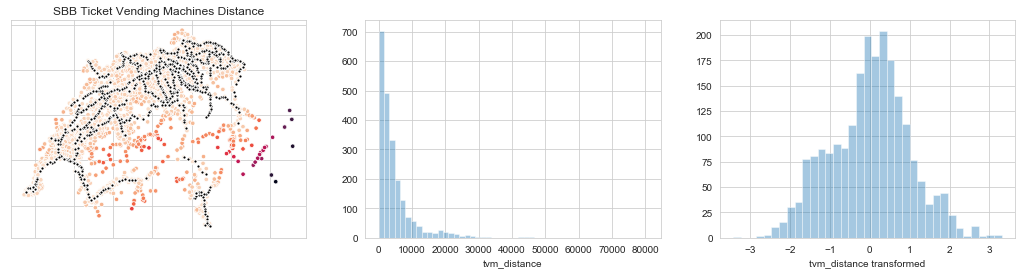

In [83]:
sns.set_style('whitegrid')
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (18, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="tvm_distance", palette="rocket_r", s=20, ax=ax0)
sns.scatterplot(data=df_tvm, x="ch_e", y="ch_n", marker=".", color="black", ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("SBB Ticket Vending Machines Distance")
sns.distplot(df["tvm_distance"], kde=False, ax=ax1)
pt = PowerTransformer()
transformed_tvm_dist = pt.fit_transform(df["tvm_distance"].values.reshape(-1, 1))
sns.distplot(transformed_tvm_dist, kde=False, ax=ax2)
ax2.set_xlabel("tvm_distance transformed")
plt.show()

In [84]:
df["transformed_tvm_dist"] = transformed_tvm_dist
df[["tvm_distance","transformed_tvm_dist", "e_cntr", "n_cntr", "po_value"]].corr()

,tvm_distance,transformed_tvm_dist,e_cntr,n_cntr,po_value
tvm_distance,1.000000,0.776781,0.218859,-0.248390,0.202198
transformed_tvm_dist,0.776781,1.000000,0.049621,-0.251283,0.240170
e_cntr,0.218859,0.049621,1.000000,0.330853,0.467519
n_cntr,-0.248390,-0.251283,0.330853,1.000000,0.277844
po_value,0.202198,0.240170,0.467519,0.277844,1.000000


In [85]:
df.drop(columns="transformed_tvm_dist", inplace=True)

### Distance from airport

In [86]:
# must be int64, int32 will overflow
# ZRH, GVA, BSL, MXP airport coordinates (manually derived)
airports = np.array([(2684745, 1256137), (2497416, 1121168), (2607041, 1272133), (2700520, 1054540)], dtype=np.int64) 

def airport_dist(e, n):
    # distance from coordinates (e, n) to nearest airport
    return (np.sqrt((e - airports[:,0])**2 + (n - airports[:,1])**2)).min()

In [87]:
# calculcate airport distance for all communes
df["airport_distance"] = df.apply(lambda row: airport_dist(row["e_cntr"], row["n_cntr"]), axis=1)

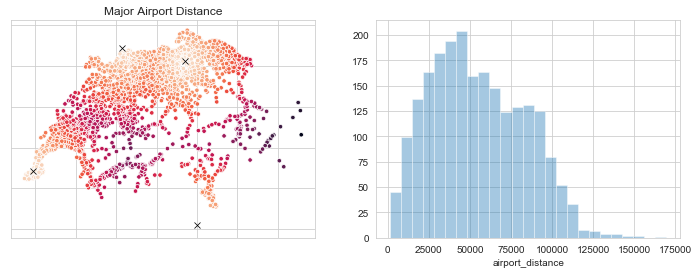

In [88]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="airport_distance", palette="rocket_r", s=20, ax=ax0)
sns.scatterplot(x=airports[:,0], y=airports[:,1], marker="x", color="black", ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("Major Airport Distance")
sns.distplot(df["airport_distance"], kde=False, ax=ax1)
plt.show()

In [89]:
df[["airport_distance", "e_cntr", "n_cntr", "po_value"]].corr()

,airport_distance,e_cntr,n_cntr,po_value
airport_distance,1.000000,0.034298,-0.472547,0.063903
e_cntr,0.034298,1.000000,0.330853,0.467519
n_cntr,-0.472547,0.330853,1.000000,0.277844
po_value,0.063903,0.467519,0.277844,1.000000


### Distance from Geneva

In [90]:
# UNO 2499842, 1120293
geneva = np.array([2499842, 1120293], dtype=np.int64)
def geneva_dist(e, n):
    # distance from coordinates (e, n) to Geneva, Palais des Nations
    return (np.sqrt((e - geneva[0])**2 + (n - geneva[1])**2))

# calculcate airport distance for all communes
df["geneva_distance"] = df.apply(lambda row: geneva_dist(row["e_cntr"], row["n_cntr"]), axis=1)

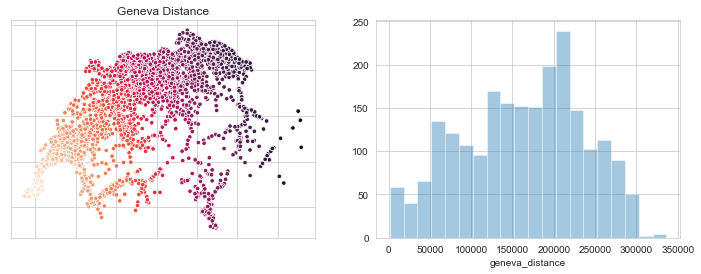

In [91]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="geneva_distance", palette="rocket_r", s=20, ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("Geneva Distance")
sns.distplot(df["geneva_distance"], kde=False, ax=ax1)
plt.show()

In [92]:
df[["geneva_distance", "e_cntr", "n_cntr", "po_value"]].corr()

,geneva_distance,e_cntr,n_cntr,po_value
geneva_distance,1.000000,0.962304,0.556679,0.460372
e_cntr,0.962304,1.000000,0.330853,0.467519
n_cntr,0.556679,0.330853,1.000000,0.277844
po_value,0.460372,0.467519,0.277844,1.000000


## Save the extended data set

In [93]:
df.to_csv(os.path.join("data", "processed", "all_data2.csv"))

# Appendix

## Commune mergers
<a class="anchor" id="commune-mergers"></a>
Some data files are older than the regional portrait file. In between, communes may have merged to new communes, which leads to missing data after a join. The table shows which communes are affected.

**Date**|**New commune**|**New Id**|**Old commune 1**|**Old Id 1**|**Old commune 2**|**Old Id 2**|**Old commune 3**|**Old Id 3**|**Old commune 4**|**Old Id 4**|**Old commune 5**|**Old Id 5**|**Old commune 6**|**Old Id 6**|**Old commune 7**|**Old Id 7**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
01.01.2019|Stammheim|292|Oberstammheim|36|Unterstammheim|42|Waltalingen|44|-|-|-|-|-|-|-|-
01.01.2019|Wädenswil|293|Hütten|134|Schönenberg (ZH)|140|Wädenswil|142|-|-|-|-|-|-|-|-
01.01.2018|Elgg|294|Elgg|217|Hofstetten (ZH)|222|-|-|-|-|-|-|-|-|-|-
01.01.2018|Horgen|295|Hirzel|132|Horgen|133|-|-|-|-|-|-|-|-|-|-
01.01.2020|Thurnen|889|Kirchenthurnen|873|Lohnstorf|874|Mühlethurnen|876|-|-|-|-|-|-|-|-
01.01.2017|Estavayer|2054|Bussy|2004|Estavayer-le-Lac|2015|Morens|2033|Murist|2034|Rueyres-les-Prés|2039|Vuissens|2049|Vernay|2052
01.01.2017|Cheyres-Châbles|2055|Châbles|2005|Cheyres|2010|-|-|-|-|-|-|-|-|-|-
01.01.2020|Villaz|2117|Villaz-Saint-Pierre|2111|La Folliaz|2116|-|-|-|-|-|-|-|-|-|-
01.01.2020|Prez|2237|Corserey|2185|Noréaz|2213|Prez-vers-Noréaz|2221|-|-|-|-|-|-|-|-
01.01.2018|Bergün Filisur|3544|Bergün|3521|Filisur|3522|-|-|-|-|-|-|-|-|-|-
01.01.2019|Rheinwald|3714|Hinterrhein|3691|Nufenen|3693|Splügen|3694|-|-|-|-|-|-|-|-
02.04.2017|Riviera|5287|Cresciano|5283|Iragna|5284|Lodrino|5285|Osogna|5286|-|-|-|-|-|-
01.01.2016|Jorat-Mézières|5806|Carrouge|5782|Ferlens|5789|Mézières|5791|-|-|-|-|-|-|-|-
01.01.2017|Goms|6077|Blitzingen|6055|Niederwald|6064|Grafschaft|6073|Münster-Geschinen|6074|Reckingen-Gluringen|6075|-|-|-|-
01.01.2017|Crans-Montana|6253|Chermignon|6234|Mollens|6242|Montana|6243|Randogne|6244|-|-|-|-|-|-
01.01.2018|La Grande Béroche|6417|Bevaix|6402|Fresens|6409|Gorgier|6410|Montalchez|6411|Saint-Aubin-Sauges|6414|Vaumarcus|6415|-|-